In [24]:
import cv2
import numpy as np
import mss
import pyperclip
from paddleocr import PaddleOCR

# 전역 ROI (x1, y1, x2, y2)
ROI = None

In [25]:
def capture_fullscreen(monitor_index: int = 1):
    """
    현재 모니터 전체 화면을 캡쳐해서 BGR(OpenCV) 이미지로 반환합니다.
    monitor_index:
        1 = 기본(primary) 모니터
        2,3,... = 추가 모니터
    """
    with mss.mss() as sct:
        monitor = sct.monitors[monitor_index]  # 1: primary
        sct_img = sct.grab(monitor)            # BGRA
        img = np.array(sct_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return img

# 테스트 캡쳐
img = capture_fullscreen()
print("캡쳐 크기:", img.shape)  # (H, W, 3)


캡쳐 크기: (1080, 1920, 3)


In [26]:
def select_roi_on_screenshot(monitor_index: int = 1):
    """
    전체 화면을 캡쳐한 뒤, 마우스로 ROI를 지정해서
    전역 변수 ROI(x1,y1,x2,y2)에 저장합니다.
    """
    global ROI
    
    img = capture_fullscreen(monitor_index=monitor_index)
    clone = img.copy()

    # ROI 선택 창 띄우기 (드래그 후 Enter, 취소는 c/ESC)
    r = cv2.selectROI("Select ROI (Enter: OK, ESC: Cancel)", clone, 
                      showCrosshair=True, fromCenter=False)
    cv2.destroyAllWindows()

    x, y, w, h = r
    if w == 0 or h == 0:
        print("ROI 선택이 취소되었습니다.")
        ROI = None
        return
    
    ROI = (int(x), int(y), int(x + w), int(y + h))
    print("선택된 ROI:", ROI)

def crop_with_roi(img, roi=None):
    """
    img에서 roi(x1,y1,x2,y2) 영역만 잘라서 반환합니다.
    roi가 None이면 전체 이미지를 그대로 반환합니다.
    """
    if roi is None:
        return img
    x1, y1, x2, y2 = roi
    return img[y1:y2, x1:x2]

# === 사용 예시 ===
# 1) 처음 한 번 ROI 선택
select_roi_on_screenshot(monitor_index=1)

# 2) 선택된 ROI로 crop 테스트
test_img = capture_fullscreen()
crop_img = crop_with_roi(test_img, ROI)

# crop 결과 확인 (원하시면 주석 해제)
cv2.imshow("Cropped", crop_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


선택된 ROI: (515, 195, 763, 292)


In [18]:
# PaddleOCR 초기화 (처음 한 번만 다소 시간이 걸릴 수 있습니다.)
ocr = PaddleOCR(
    use_angle_cls=True,  # 회전/기울기 보정
    lang="korean",       # 'korean', 'en', 'ch' 등
)

print("PaddleOCR 초기화 완료")



C:\Users\snk74\AppData\Local\Temp\ipykernel_31176\3278700258.py:2: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\snk74\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\snk74\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\snk74\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually:

PaddleOCR 초기화 완료


In [ ]:
import tempfile
import os

def ocr_image_to_text(img_bgr, scale=2.0):
    """
    BGR(OpenCV) 이미지에서 텍스트를 추출해 문자열로 합쳐 반환합니다.
    - scale: 2.0이면 가로/세로 2배로 키워서 인식 (작은 글씨 대응)
    """
    # 1) 이미지 확대
    h, w = img_bgr.shape[:2]
    if scale != 1.0:
        img_bgr = cv2.resize(
            img_bgr,
            (int(w * scale), int(h * scale)),
            interpolation=cv2.INTER_LINEAR,
        )

    # 2) (선택) 약간 선명하게 만들고 싶으면 샤프닝 필터도 가능
    # kernel = np.array([[0, -1, 0],
    #                    [-1, 5, -1],
    #                    [0, -1, 0]], np.float32)
    # img_bgr = cv2.filter2D(img_bgr, -1, kernel)

    # 3) 임시 파일로 저장 후 경로 기반으로 OCR
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        tmp_path = tmp.name
    cv2.imwrite(tmp_path, img_bgr)

    try:
        result = ocr.ocr(tmp_path)  # 경로로 넣기
    finally:
        # 임시 파일 삭제
        if os.path.exists(tmp_path):
            os.remove(tmp_path)

    # 4) 결과 디버깅용 출력 (원하시면 끄셔도 됨)
    # print(result)

    # 5) 텍스트만 추출
    lines = []
    for res in result:        # 보통 한 장이면 res 하나
        for line in res:
            text = line[1][0]  # (텍스트, 신뢰도)
            lines.append(text)

    return "\n".join(lines)



C:\Users\snk74\AppData\Local\Temp\ipykernel_31176\2616496819.py:6: DeprecationWarning: Please use `predict` instead.
  result = ocr.ocr(img_bgr)


n
a
o
t
o
e
e
e
e
e
e
e
i
e
e


In [22]:
def capture_crop_ocr_to_clipboard(monitor_index: int = 1):
    """
    전체 화면 캡쳐 → ROI로 Crop → OCR → 클립보드에 텍스트 저장
    """
    if ROI is None:
        print("ROI가 아직 설정되지 않았습니다. 먼저 select_roi_on_screenshot()을 실행해 주세요.")
        return None
    
    # 1) 전체 화면 캡쳐
    img = capture_fullscreen(monitor_index=monitor_index)
    
    # 2) ROI로 Crop
    crop_img = crop_with_roi(img, ROI)
    
    # 3) OCR 수행
    text = ocr_image_to_text(crop_img)
    
    # 4) 클립보드에 복사
    pyperclip.copy(text)
    print("아래 텍스트를 클립보드에 복사했습니다.\n")
    print(text)
    
    return text

# === 실제 사용 ===
# 필요할 때마다 이 셀만 실행하시면 됩니다.
capture_crop_ocr_to_clipboard(monitor_index=1)


C:\Users\snk74\AppData\Local\Temp\ipykernel_31176\2616496819.py:6: DeprecationWarning: Please use `predict` instead.
  result = ocr.ocr(img_bgr)


아래 텍스트를 클립보드에 복사했습니다.

n
a
o
t
o
e
e
e
e
e
e
e
i
e
e


'n\na\no\nt\no\ne\ne\ne\ne\ne\ne\ne\ni\ne\ne'

crop shape: (97, 248, 3)


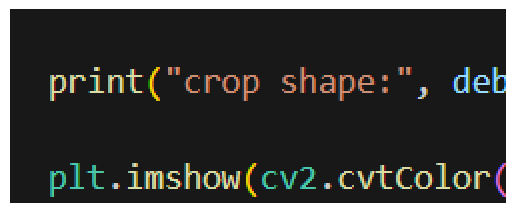

In [27]:
import matplotlib.pyplot as plt

# %matplotlib inline  # 보통 Jupyter면 없어도 되지만, 안 나오면 이 줄도 같이 실행

debug_img = capture_fullscreen()
debug_crop = crop_with_roi(debug_img, ROI)

print("crop shape:", debug_crop.shape)

plt.imshow(cv2.cvtColor(debug_crop, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
